# Sentinel 2 + Landsat animation with hydrograph

In [1]:
# Import modules
import datacube 
import sys
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from skimage import exposure
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datetime import datetime, timedelta

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting
import TasseledCapTools

# Set up datacube instances
dc = datacube.Datacube(app='Time series animation')
s2dc = datacube.Datacube(config='/g/data/r78/dc_configs/sentinel2.conf')

# Study area name used for output file
study_area = 'hattah'

# Thresholds used for cloud masking (Sentinel 2 is more aggressive)
landsat_masked_prop = 0.99
sentinel_masked_prop = 0.90

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -34.7275016476, 142.367987284, 5000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 10000, x + 10000),
         'y': (y - buffer, y + buffer),    
         'time': ('2014-01-01', '2018-07-30'),
         'crs': 'EPSG:3577'}

%load_ext autoreload
%autoreload 2

## Extract cloud-free clear Landsat and Sentinel observations
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. 

Load in Sentinel data for S2A and S2B.

In [2]:
# # Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
# custom_mask = {'cloud_acca': 'no_cloud', 
#                'cloud_fmask': 'no_cloud', 
#                'cloud_shadow_acca': 'no_cloud_shadow',
#                'cloud_shadow_fmask': 'no_cloud_shadow',
#                'contiguous': True}

# # Load in data
# ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
#                                         #bands_of_interest=['green', 'nir', 'swir1', 'red'], 
#                                         masked_prop=landsat_masked_prop, mask_dict=custom_mask, apply_mask=False)  

# # Remove problematic timesteps
# problem_times = ['2015-08-02', '2015-08-18', '2016-03-13', '2016-04-30', '2017-05-03', '2015-04-28']
# times_to_drop = [ls578_ds.time.loc[i].values for i in problem_times]

# # Remove timesteps
# ls578_ds = ls578_ds.drop(np.concatenate(times_to_drop), dim="time")


In [7]:
combined_ds = xr.open_dataset('/g/data1a/r78/rjd547/Macquarie_Marsh/hattah_median_interp2.netcdf')

In [8]:
combined_ds

<xarray.Dataset>
Dimensions:    (time: 187, x: 712, y: 401)
Coordinates:
  * y          (y) float64 -3.825e+06 -3.825e+06 -3.825e+06 -3.825e+06 ...
  * x          (x) float64 9.361e+05 9.361e+05 9.361e+05 9.362e+05 9.362e+05 ...
  * time       (time) datetime64[ns] 2008-03-07T00:11:23 2008-06-19T00:08:34 ...
Data variables:
    red        (time, y, x) float64 ...
    green      (time, y, x) float64 ...
    blue       (time, y, x) float64 ...
    nir        (time, y, x) float64 ...
    swir1      (time, y, x) float64 ...
    swir2      (time, y, x) float64 ...
    data_perc  (time) float64 ...

## Plot data as animation

In [9]:
tci = TasseledCapTools.thresholded_tasseled_cap(combined_ds, wetness_threshold=-350, drop_tc_bands=False)

In [15]:
tci.dims


Frozen(SortedKeysDict(OrderedDict([('y', 401), ('x', 712), ('time', 187)])))

In [16]:
#create a value for tci over threshold brightness, wetness, greenness for each timestep. add into a pandas dataframe and 
tci_count = tci.count(dim=['x','y'])

In [29]:
tci_df = tci_count.to_dataframe()

In [31]:
tci_df

,greenness,greenness_thresholded,brightness,brightness_thresholded,wetness,wetness_thresholded
time,,,,,,
2008-03-07 00:11:23.000000000,285512,3687,285512,205485,285512,2501
2008-06-19 00:08:34.000000000,285512,3478,285512,197235,285512,2443
2008-10-01 00:05:45.000000000,285512,7388,285512,178456,285512,2349
2008-10-09 00:05:29.249999872,285512,3665,285512,169841,285512,2230
2008-10-17 00:05:13.500000000,285512,2988,285512,163970,285512,2128
2008-11-18 00:05:23.500000000,285512,3300,285512,165883,285512,1973
2008-12-20 00:05:33.500000000,285512,3496,285512,167708,285512,1434
2008-12-28 00:05:46.249999872,285512,3699,285512,168885,285512,1246
2009-01-05 00:05:59.000000000,285512,3866,285512,170219,285512,839


In [35]:
tci_df2 = tci_df[['wetness_thresholded','brightness_thresholded','greenness_thresholded']]

In [36]:
tci_df2

,wetness_thresholded,brightness_thresholded,greenness_thresholded
time,,,
2008-03-07 00:11:23.000000000,2501,205485,3687
2008-06-19 00:08:34.000000000,2443,197235,3478
2008-10-01 00:05:45.000000000,2349,178456,7388
2008-10-09 00:05:29.249999872,2230,169841,3665
2008-10-17 00:05:13.500000000,2128,163970,2988
2008-11-18 00:05:23.500000000,1973,165883,3300
2008-12-20 00:05:33.500000000,1434,167708,3496
2008-12-28 00:05:46.249999872,1246,168885,3699
2009-01-05 00:05:59.000000000,839,170219,3866


In [ ]:
DEAPlotting.animated_timeseries(ds=combined_ds,
                    output_path='{}_simple_false.mp4'.format(study_area), 
                    bands=['swir1', 'nir', 'green'], 
                    interval=200,
                    show_date=False,
                    title=tci.time.dt.year.values.tolist(),
                    width_pixels=500,
                    reflect_stand=4300)

    Exporting animation to hattah_simple_false.mp4


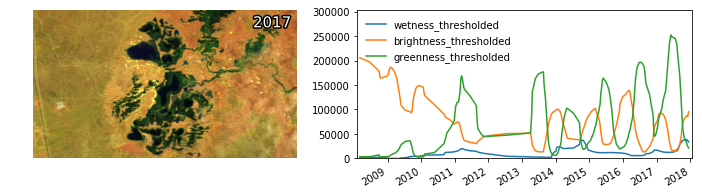

In [37]:
DEAPlotting.animated_timeseriesline(ds=combined_ds,
                    df=tci_df2,
                    output_path='{}_simple_false.mp4'.format(study_area), 
                    bands=['swir1', 'nir', 'green'], 
                    interval=200,
                    show_date=False,
                    title=tci.time.dt.year.values.tolist(),
                    width_pixels=500,
                    reflect_stand=4300)

In [26]:
# # Create animation
# DEAPlotting.animated_timeseriesline(ds=combined_ds, # .isel(time=[0,1,2,3,4,5]), 
#                         df=line_df, 
#                         output_path='{}_audio.gif'.format(study_area), 
#                         bands=['swir1', 'nir', 'green'], 
#                         interval=200, 
#                         annotation_kwargs={'fontsize':17},
#                         reflect_stand=4200)

In [25]:
# # Create animation
# DEAPlotting.animated_timeseriesline(ds=tci,#.isel(time=[0,1,2,3,4,5]), 
#                         #df=line_df, 
# #                         output_path='{}_audio_sentinel2.gif'.format(study_area), 
#                         bands=['wetness_thresholded'], 
#                         onebandplot_cbar=False, 
#                         onebandplot_kwargs={'cmap':'gist_earth_r','vmin':tci.wetness_thresholded.min(),
#                                            'vmax':tci.wetness_thresholded.max()},
#                         interval=220, 
#                         annotation_kwargs={'fontsize':17},
#                         reflect_stand=4200
#                                    )

In [39]:
tci_df2.to_csv('tci_df.csv')

In [40]:
tci_df2 = pd.read_csv('tci_df.csv')